# Deep Support Vector Data Description

From Ruff 2018. The architecture and hyperparameters values are directly taken from the paper as a first test.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# DRIVE
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.decision.reconstruction import binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

2.3.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mon Aug 10 13:20:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import data

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

interest_digit = 0

# x_val, y_val_bin = x_train[-1000:], binarize_set(y_train[-1000:], interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

x_val = np.concatenate((digits_train[0][:500], digits_train[1][:50], 
                        digits_train[2][:50], digits_train[3][:50],
                        digits_train[4][:50], digits_train[5][:50],
                        digits_train[6][:50], digits_train[7][:50],
                        digits_train[8][:50], digits_train[9][:100]), axis=0)
y_val_bin = np.concatenate((np.zeros(500), np.ones(500)), axis=0)

# training set contains only zeros (for training on zeros)
labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit][:-500], y_train[np.where(y_train[:-500] == interest_digit)][:-500]
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape, x_val.shape, y_val_bin.shape)

(5325, 28, 28, 1) (5377,) (1000, 28, 28, 1) (1000,)


## DeepSVDD class

## Define architecture

In [8]:
from uad.models.one_class import DeepSVDD

from uad.models.architecture import get_unet_svdd

n_filters, n_contractions, dense_sizes = 8, 4, 16
input_dims = (28, 28, 1)
latent_depth = 8
latent_dims = (int(256 / (2**n_contractions)), int(32 / (2**n_contractions)), 
               latent_depth)
batchnorm, dropout, spatial_dropout = False, 0.2, 0
activation_function = "leaky_relu"
self_attention = False
padding = [[0, 0], [2, 2], [2, 2], [0, 0]]

LAMBDA = 1e-6

archi = get_unet_svdd(n_filters=n_filters, n_contractions=n_contractions,
                                dense_sizes=dense_sizes, input_dims=input_dims, 
                                batchnorm=batchnorm, dropout=dropout, padding=padding, 
                                spatial_dropout=spatial_dropout, activation_function=activation_function,
                                latent_depth=latent_depth, self_attention=self_attention, LAMBDA=1e-6)

print(archi.summary())

# def get_ruff_model():
#     """
#     Architecture of the model in Ruff 2018
#     """
#     n_filters = (16, 32, 64)
#     dense_shape = 32
#     LAMBDA = 1e-6

#     inputs = tf.keras.Input(shape=(28, 28, 1))
#     paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
#     x = tf.pad(inputs, paddings, name="pad")

#     c1 = layers.Conv2D(filters=n_filters[0], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                              padding="same", name=f"conv_1")(x)
#     b1 = layers.BatchNormalization()(c1)
#     a1 = layers.LeakyReLU(alpha=0.1, name=f"activation_1")(c1)
#     mp1 = layers.MaxPooling2D((2, 2), name=f"max_pooling_1")(a1)
    
#     c2 = layers.Conv2D(filters=n_filters[1], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                             padding="same", name=f"conv_2")(mp1)
#     b2 = layers.BatchNormalization()(c2)
#     a2 = layers.LeakyReLU(alpha=0.1, name=f"activation_2")(b2)
#     mp2 = layers.MaxPooling2D((2, 2), name=f"max_pooling_2")(a2)

#     c3 = layers.Conv2D(filters=n_filters[2], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                             padding="same", name=f"conv_3")(mp2)
#     b3 = layers.BatchNormalization()(c3)
#     a3 = layers.LeakyReLU(alpha=0.1, name=f"activation_3")(b3)
#     mp3 = layers.MaxPooling2D((2, 2), name=f"max_pooling_3")(a3)
#     f3 = layers.Flatten()(mp3)
    
#     d4 = layers.Dense(64, kernel_regularizer=l2(LAMBDA))(f3)
#     outputs = layers.Dense(32, kernel_regularizer=l2(LAMBDA))(d4)

#     return tf.keras.Model(inputs, outputs)

[[0, 0], [2, 2], [2, 2], [0, 0]]
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
tf_op_layer_pad_1 (TensorFlo [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 8)         32        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 8)         256       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_6 (MaxP

In [ ]:
# def conv2d_block(input_tensor, n_filters, kernel_size=3, LAMBDA=1e-6):
#     """Function to add 2 convolutional layers with the parameters passed to it
#     activation1: name of the activation function to apply. If none, pass "" (empty string)
#     activation2: name of the activation function to apply. If none, pass "" (empty string)
#     """
#     # first layer
#     x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
#                       kernel_regularizer=l2(LAMBDA), bias_regularizer=l2(LAMBDA), 
#                       kernel_initializer='he_normal', padding='same')(input_tensor)
#     x = layers.LeakyReLU(alpha=0.1)(x)
#     # second layer
#     x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
#                       kernel_regularizer=l2(LAMBDA), bias_regularizer=l2(LAMBDA), 
#                       kernel_initializer='he_normal', padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.1)(x)

#     return x


# def get_model():
#     """
#     More complex architecture inspired from our standard encoder
#     """
#     n_filters = 8
#     dense_shape = 32
#     LAMBDA = 1
#     dropout = None
#     k_size = 3

#     inputs = layers.Input(shape=(28, 28, 1), name="inputs")
#     paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
#     x = tf.pad(inputs, paddings, name="pad")

#     x = conv2d_block(x, n_filters * 1, kernel_size=k_size, LAMBDA=LAMBDA)
#     x = layers.MaxPooling2D((2, 2))(x)
#     # x = layers.Dropout(dropout)(x)

#     x = conv2d_block(x, n_filters * 2, kernel_size=k_size, LAMBDA=LAMBDA)
#     x = layers.MaxPooling2D((2, 2))(x)
#     # x = layers.Dropout(dropout)(x)

#     x = conv2d_block(x, n_filters=n_filters * 4, kernel_size=k_size, LAMBDA=LAMBDA)
#     x = layers.MaxPooling2D((2, 2))(x)
#     # x = layers.Dropout(dropout)(x)

#     x = conv2d_block(x, 1, kernel_size=k_size, LAMBDA=LAMBDA)

#     outputs = layers.Flatten()(x)

#     return tf.keras.Model(inputs, outputs)

# m = get_model()

# print(m.summary())

## Callbacks

We have two callbacks:
- On train begin: Initialize the center as the barycentre of the predictions after one initial forward pass.
- Learning rate schedule: Reduce LR after epoch 50 and 100.

In [ ]:
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_curve
# from uad.decision.reconstruction import is_anormal
# from uad.diagnostic.metrics import compute_recall, compute_precision, compute_f1

# class InitializeCenterCallback(tf.keras.callbacks.Callback):
#     """
#     Allows to modify the center of a One-Class neural network after each epoch, replacing it with the
#     barycentre (still a tensor) of each predictions on the training set. This could improve convergence of the modelss
#     """

#     def __init__(self, x_train):
#         """
#         Train data from which to compute the center
#         """
#         self.x_train = x_train

#     def on_train_begin(self, logs=None):
#         predictions = self.model.predict(self.x_train)
#         center = tf.reduce_mean(predictions, axis=0)
#         self.model.set_center(center)
#         print("Center initialized.")
#         print(self.model.CENTER)


# def lr_scheduler(epoch, lr):
#     if epoch == 50:
#         lr /= 2
#     elif epoch == 100:
#         lr /= 2
#     return lr

# init_center_callb = InitializeCenterCallback(x_train_bin)
# lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

## Pretrain an AE and get the encoder weights

In [14]:
# def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation1="sigmoid",
#                  activation2="sigmoid"):
#     """Function to add 2 convolutional layers with the parameters passed to it
#     activation1: name of the activation function to apply. If none, pass "" (empty string)
#     activation2: name of the activation function to apply. If none, pass "" (empty string)
#     """
#     # first layer
#     x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
#                       kernel_initializer='he_normal', padding='same')(input_tensor)
#     if batchnorm:
#         x = layers.BatchNormalization()(x)
#     if activation1 != "":
#         x = layers.Activation(activation1)(x)

#     # second layer
#     x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
#                       kernel_initializer='he_normal', padding='same')(input_tensor)
#     if batchnorm:
#         x = layers.BatchNormalization()(x)
#     if activation2 != "":
#         x = layers.Activation(activation2)(x)

#     return x

# class AE(Model):

#     def __init__(self, encoder, decoder):
#         super(AE, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def train_step(self, data):
#         if isinstance(data, tuple):
#             data = data[0]
#         with tf.GradientTape() as tape:
#             z = self.encoder(data)
#             reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.keras.losses.binary_crossentropy(data, reconstruction)
#             )
#             reconstruction_loss *= 28 * 28
#             total_loss = reconstruction_loss
#         grads = tape.gradient(total_loss, self.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
#         return {
#             "loss": total_loss,
#             "reconstruction_loss": reconstruction_loss,
#         }

#     def call(self, data):
#         if isinstance(data, tuple):
#             data = data[0]
#         prediction = self.encoder(data)
#         return self.decoder(prediction)

# n_filters = (16, 32, 64)
# dense_shape = 32
# LAMBDA = 1e-6

# input_size = (28, 28, 1)
# n_filters = (16, 32, 64)
# batchnorm = True
# dropout = 0.2
# k_size = 3

# inputs = tf.keras.Input(shape=(28, 28, 1))
# paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
# x = tf.pad(inputs, paddings, name="pad")

# c1 = layers.Conv2D(filters=n_filters[0], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                             padding="same", name=f"conv_1")(x)
# b1 = layers.BatchNormalization()(c1)
# a1 = layers.LeakyReLU(alpha=0.1, name=f"activation_1")(c1)
# mp1 = layers.MaxPooling2D((2, 2), name=f"max_pooling_1")(a1)

# c2 = layers.Conv2D(filters=n_filters[1], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                         padding="same", name=f"conv_2")(mp1)
# b2 = layers.BatchNormalization()(c2)
# a2 = layers.LeakyReLU(alpha=0.1, name=f"activation_2")(b2)
# mp2 = layers.MaxPooling2D((2, 2), name=f"max_pooling_2")(a2)

# c3 = layers.Conv2D(filters=n_filters[2], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
#                         padding="same", name=f"conv_3")(mp2)
# b3 = layers.BatchNormalization()(c3)
# a3 = layers.LeakyReLU(alpha=0.1, name=f"activation_3")(b3)
# mp3 = layers.MaxPooling2D((2, 2), name=f"max_pooling_3")(a3)
# f3 = layers.Flatten()(mp3)

# d4 = layers.Dense(64, kernel_regularizer=l2(LAMBDA))(f3)
# z = layers.Dense(32, kernel_regularizer=l2(LAMBDA))(d4)

# encoder = tf.keras.Model(inputs, z)

# latent_inputs = tf.keras.Input(shape=(32,))
# x = layers.Reshape((4, 4, 2))(latent_inputs)
# paddings2 = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
# p2 = tf.pad(x, paddings2, name="pad2")

# x = layers.Conv2DTranspose(n_filters[2], (k_size, k_size), strides=(2, 2), padding='same', name="u6")(
#     p2)
# x = layers.Dropout(dropout)(x)
# x = conv2d_block(x, n_filters[2], kernel_size=k_size, batchnorm=batchnorm)

# x = layers.Conv2DTranspose(n_filters[1], (k_size, k_size), strides=(2, 2), padding='same', name="u7")(x)
# x = layers.Dropout(dropout)(x)
# x = conv2d_block(x, n_filters[1], kernel_size=k_size, batchnorm=batchnorm)

# x = layers.Conv2DTranspose(n_filters[0], (k_size, k_size), strides=(2, 2), padding='same', name="u8")(x)
# x = layers.Dropout(dropout)(x)
# decoder_outputs = conv2d_block(x, 1, kernel_size=k_size, batchnorm=batchnorm)
# crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

# decoder = Model(inputs=latent_inputs, outputs=crop, name="decoder")

# r = AE(encoder, decoder)

In [ ]:
r.compile(optimizer=tf.keras.optimizers.Adam())
# r.fit(x_train_bin, x_train_bin, epochs=30, batch_size=64)

In [ ]:
# r.encoder.save_weights("gdrive/My Drive/BACMMAN_DISTNET/UAD_BACT/MNIST_one_vs_all/saved_models/encoder_weights")  # intial weights of svdd

In [ ]:
# r = get_ruff_model()

# svdd = DeepSVDD(r, out_shape=32, LAMBDA=1e-6)
# svdd.compile(optimizer=tf.keras.optimizers.Adam())

# # initialize the weights with pretrained VAE weights as done in Ruff 2020
# svdd.load_weights("saved_models/encoder_weights")


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard

svdd = DeepSVDD(archi, final_dense_shape=dense_sizes, LAMBDA=LAMBDA)
svdd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

reduce_lr = ReduceLROnPlateau(
    monitor='val_reconstruction_loss', factor=0.1, patience=5, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0,)

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = svdd.fit(x_train_bin, x_train_bin, validation_data=(x_val, y_val_bin), epochs=100, batch_size=128, callbacks=[tensorboard_callback, reduce_lr])

In [16]:
n_filters, n_contractions, LAMBDA = 16, 3,  1e-6
n_classes, replicas = 10, 10
epochs = 30
auc_scores = np.zeros((10, replicas))  # (digits, replicas)

for k in range(n_classes):  # each digit
    for i in range(replicas): # 10 replicas
        archi = get_unet_svdd(n_filters=n_filters, n_contractions=n_contractions,
                                dense_sizes=dense_sizes, input_dims=input_dims, 
                                batchnorm=batchnorm, dropout=dropout, padding=padding, 
                                spatial_dropout=spatial_dropout, activation_function=activation_function,
                                latent_depth=latent_depth, self_attention=self_attention, LAMBDA=1e-6)
        model = DeepSVDD(archi, final_dense_shape=16, LAMBDA=LAMBDA)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
        model.fit(digits_train[k], digits_train[k], epochs=epochs, batch_size=128, verbose=0)
        predictions = model.score_samples(x_test)
        y_test_bin = binarize_set(y_test, interest=k)
        fpr, tpr, _ = model.compute_ROC(y_test_bin, predictions)
        auc = compute_AUC(fpr, tpr)
        print(f"Digit {k}, Iteration {i}, Final AUC: {auc}")
        auc_scores[k, i] = auc

print(auc_scores)
np.save("/content/gdrive/My Drive/BACMMAN_DISTNET/models/auc_per_class_MNIST_10replicas", auc_scores)

[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 0, Final AUC: 0.9099414000633512
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 1, Final AUC: 0.8664353590660211
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 2, Final AUC: 0.9071866374044075
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 3, Final AUC: 0.7780078849721708
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 4, Final AUC: 0.9141581067016606
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 5, Final AUC: 0.8659076202543101
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 6, Final AUC: 0.6285338703108738
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 7, Final AUC: 0.8826466129689127
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 8, Final AUC: 0.8640465631929047
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 0, Iteration 9, Final AUC: 0.8145617448753338
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 1, Iteration 0, Final AUC: 0.9124771722683126
[[0, 0], [2, 2], [2, 2], [0, 0]]
Digit 1, Iteration 1, Final AUC:

In [17]:
# mean +- std over 10 iterations for each class

stats = np.array([[np.mean(row), np.std(row)] for row in auc_scores])
print(stats * 100)

[[84.314258    8.23295605]
 [89.1317044   8.81266096]
 [70.14448552  3.83517852]
 [72.8931877  11.32172335]
 [79.53144458  2.6208724 ]
 [68.41760853  5.39154006]
 [82.42389032  9.45648143]
 [77.16159201  6.82099478]
 [73.41200939 10.71036329]
 [69.8650969  15.99232398]]


In [ ]:
predictions = svdd.predict(x_test)
center = np.reshape(svdd.CENTER.numpy(), (1, 32))

In [ ]:
print(svdd.score_samples(x_test[:10]) * 10**5)
print(y_test_bin[:10])

[0.07395702 0.16567328 0.08631873 0.07818704 0.04871024 0.08678437
 0.07675123 0.19492425 0.06796109 0.07610772]
[1 1 1 0 1 1 1 1 1 1]


## Plot prediction norms distribution

To adjust the threshold given to is_anormal function



(10000,)


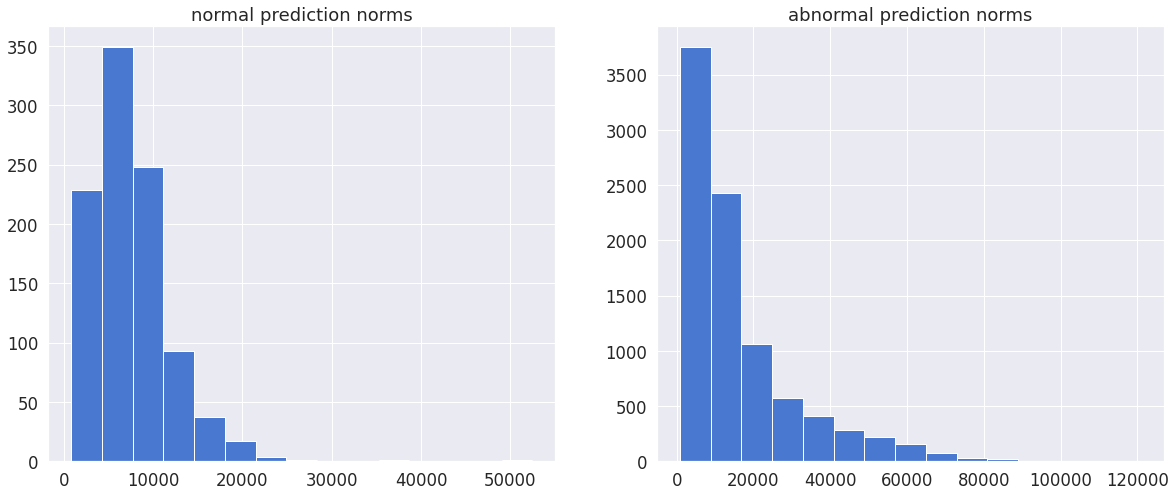

In [12]:
normal_norms, abnormal_norms = [], []

y_scores = svdd.score_samples(x_test)

for score, lab in zip(y_scores, y_test_bin):
    if lab == 0:
        normal_norms.append(score)
    else:
        abnormal_norms.append(score)
        
normal_norms = np.array(normal_norms) * 10**5
abnormal_norms = np.array(abnormal_norms) * 10**5

print(y_scores.shape)

fig, axis = plt.subplots(1, 2, figsize=(20, 8))
for ax, n, title in zip(axis.flatten(), [normal_norms, abnormal_norms], ["normal prediction norms", "abnormal prediction norms"]):
    ax.hist(n, bins=15)
    ax.set_title(title)


## Plot ROC

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8307829e8>)

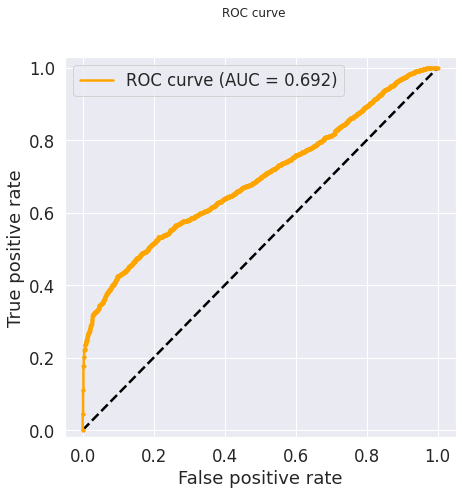

In [13]:
y_scores = svdd.score_samples(x_test)

fprs, tprs, _ = svdd.compute_ROC(y_test_bin, y_scores)

plot_ROC(fprs, tprs)

## t-SNE visualisation

In [ ]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123


def compute_tSNE(dataset, desired_axis=-1):
    """
    Performs tSNE projection on the given dataset, along the desired axis. If a
    third-rank is given, takes the mean of the other axis, to get a final vector
    along the desired axis (since t-SNE only takes vectors as inputs and we don't
    want to mix the different axis)
    :param dataset: np.array
    :param desired_axis: axis on which to project the dataset (e.g. to project
    on channels : axis=-1 in channels_last configuration). None or 0 if you want to
    merge all axis in one.
    :return: an array containing the same number of items than in the given
    dataset but with the output dimension of the t-SNE transformation
    """
    if len(dataset.shape) > 2:  # third-rank tensor or matrix
        if desired_axis is None or desired_axis == 0:
            if len(dataset.shape) == 4:
                batch, x, y, z = dataset.shape
                dataset = np.reshape(dataset, (batch, x * y * z))
            elif len(dataset.shape) == 3:
                batch, x, y = dataset.shape
                dataset = np.reshape(dataset, (batch, x * y))
            elif len(dataset.shape) == 2:  # vectors batch for Deep SVDD
                batch, x = dataset.shape
                dataset = np.reshpae(dataset, (batch, x))
            else:
                raise NotImplementedError(
                    "Input dataset should either be 3 or 2-rank tensor, or batch of vectors with SVDD")
        else:  # merge only non desired axis by taking the mean along each
            axes = range(len(dataset.shape))
            axes = np.delete(axes, desired_axis)
            axes = np.delete(axes, 0)  # keep first axis (individual elements)
            while axes != []:
                dataset = np.mean(dataset, axis=axes[0])  # perform mean along the non-desired axis
                axes = [a - 1 for a in axes]
                del axes[0]
    print(f"t-SNE inputs shape: {dataset.shape}")
    return TSNE().fit_transform(dataset)


def plot_tSNE(dataset, colors, axis=-1, plot_center=None, plt_ax=None):
    """
    Plot the t-SNE projection of a given dataset
    :param dataset: t-SNE outputs
    :param colors: original labels which serve as colors
    :param plot_center: tuple with center coordinates
    :param axis: axis along which to perform t-SNE
    :param plt_ax: matplotlib axis object on which to plot the result
    :return: matplotlib figure, axis, scatter and texts
    """
    if plot_center.any():
        dataset = np.concatenate((dataset, plot_center), axis=0)
        colors = np.concatenate((colors, [-1]), axis=0)

    x = compute_tSNE(dataset, desired_axis=axis)

    print(f"t-SNE output shape: {x.shape}")

    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    #     palette = np.array(colors)

    print(num_classes)

    # create a scatter plot.
    if plt_ax is None:
        f = plt.figure(figsize=(8, 8))
        plt_ax = plt.subplot(aspect='equal')
        sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        plt_ax.axis('on')
        plt_ax.axis('tight')
    else:
        f = None
        sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        plt_ax.axis('on')
        plt_ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):
        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = plt_ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, plt_ax, sc, txts


t-SNE inputs shape: (10001, 32)
t-SNE output shape: (10001, 2)
3


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(<Figure size 576x576 with 1 Axes>,
 [Text(18.42959, 6.2711124, '0'),
  Text(-2.7875671, -1.044027, '1'),
  Text(nan, nan, '2')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


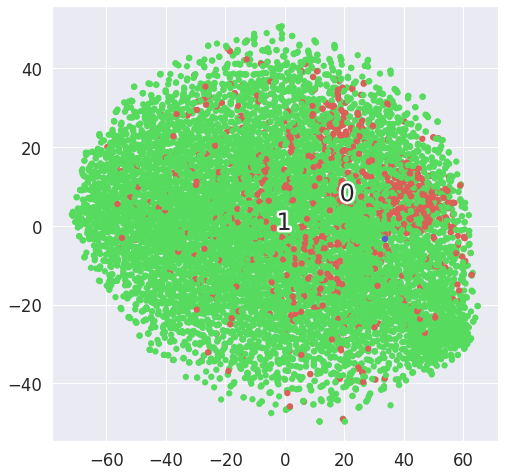

In [ ]:
plot_tSNE(predictions, y_test_bin, plot_center=center, axis=0)

On 0: the performances are really poor with this model, because zeros are not well clustered with this technique. This is inconsistent with Ruff results... Wrong implementation??

## Evaluate on all classes (AUC score)

In [ ]:
scores = DeepSVDD.evaluate_on_all(r, digits_train, x_test, y_test_bin, n_classes=10, epochs=50, LAMBDA=1e-6, dense_shape=16)

NameError: ignored

In [ ]:
for i, elt in enumerate(scores):
    print(f"Digit: {i}: AUC = {elt}")

Not the same as Ruff 2018